<br><br><br>
<font size="12em" color="#214A96" face="Krungthep">
<strong> Lyricist for All (작사봇)<br><br><br></strong>
    
![telegram](./tele_msg.png)
<div style="text-align:right">
<font size="5em" color="black" face="Chalkduster">
<br><br><br>Seunghwan Roh
</font>
<br><br>

<br><font size="5" color="#214A96" face="Futura">
<strong> Intro </strong>

    가사집(http://gasazip.com)에서 제공하는 오늘의 인기가사 TOP 100의 노랫말로 로봇작사가를 훈련시킵니다.

    로봇작사가는 그날 가장 인기 있는 가사의 감성을 담아 새로운 노랫말을 만들어줍니다.

    만들어진 노랫말은 텔레그램으로 쉽게 받아볼 수 있습니다. 

    그리고 오늘의 인기가사 TOP 100에 쓰인 단어들을 워드클라우드를 통해 알아봅니다.

<br><font size="5" color="#214A96" face="Futura">
<strong> Setting </strong>

In [12]:
from selenium import webdriver
import time
import warnings
warnings.filterwarnings("ignore")
from konlpy.tag import Okt
from nltk import bigrams, word_tokenize
from nltk.util import ngrams
from tqdm import tqdm
from nltk import ConditionalFreqDist
from nltk.probability import ConditionalProbDist, MLEProbDist
import numpy as np
import telegram
import re
from krwordrank.word import KRWordRank
from wordcloud import WordCloud
%matplotlib inline
import matplotlib.pyplot as plt

<br><font size="5" color="#214A96" face="Futura">
<strong>오늘의 인기가사 TOP100 가져오기 </strong>

In [13]:
# 셀레니움 설정하기
options = webdriver.ChromeOptions()
options.add_argument('headless')
options.add_argument('window-size=1920x1080')
options.add_argument("disable-gpu")
driver = webdriver.Chrome('chromedriver', 
                          chrome_options=options)

In [14]:
# 몇위 가사까지 가져올지 설정하기
rank = 100

# 크롤링을 수월하게 하기 위한 전처리하기
url = "http://gasazip.com/top100.html"
rank_set = []
for i in range(1, rank+1):
    rank_set.append("{}위".format(i))

In [15]:
# 크롤링 실행 및 드라이버 종료하기
lyrics_set = []   
for i in tqdm(range(rank)):
    # 인기 가사 리스트로 이동
    driver.get(url)
    time.sleep(0.3)

    # 1위~100위 노래 가사로 이동
    driver.find_element_by_partial_link_text(rank_set[i]).click()
    time.sleep(0.3)

    # 이동한 뒤 노래 가사 긁어오기
    lyrics = driver.find_element_by_css_selector("body > div.container-fluid > div > div.col-md-9 > div:nth-child(10) > div.col-md-8").text
    lyrics = lyrics.replace("\n", " ")

    # 가사 리스트에 추가
    lyrics_set.append(lyrics)



  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:07<12:19,  7.47s/it]

  2%|▏         | 2/100 [00:11<10:45,  6.59s/it]

  3%|▎         | 3/100 [00:15<09:11,  5.68s/it]

  4%|▍         | 4/100 [00:19<08:05,  5.05s/it]

  5%|▌         | 5/100 [00:22<07:21,  4.65s/it]

  6%|▌         | 6/100 [00:26<06:59,  4.46s/it]

  7%|▋         | 7/100 [00:31<07:01,  4.53s/it]

  8%|▊         | 8/100 [00:38<07:49,  5.11s/it]

  9%|▉         | 9/100 [00:42<07:15,  4.79s/it]

 10%|█         | 10/100 [00:47<07:41,  5.13s/it]

 11%|█         | 11/100 [00:53<07:34,  5.10s/it]

 12%|█▏        | 12/100 [00:57<07:13,  4.93s/it]

 13%|█▎        | 13/100 [01:06<08:43,  6.02s/it]

 14%|█▍        | 14/100 [01:11<08:23,  5.85s/it]

 15%|█▌        | 15/100 [01:15<07:22,  5.20s/it]

 16%|█▌        | 16/100 [01:18<06:33,  4.69s/it]

 17%|█▋        | 17/100 [01:22<06:12,  4.48s/it]

 18%|█▊        | 18/100 [01:27<06:01,  4.41s/it]

 19%|█▉        | 19/100 [01:30<05:33,  4.11s/it]

 20%|██        |

In [16]:
# 웹드라이버 종료하기
driver.quit()

In [17]:
# 100곡의 가사가 리스트에 모두 들어왔는지 확인하기
len(lyrics_set)

100

<br><font size="5" color="#214A96" face="Futura">
<strong>작사봇 훈련시키기</strong>

In [18]:
# 한글 자연어 처리기 Okt를 사용
# nltk의 bigrams, word_tokenize, ngram 사용
tagger = Okt()

def tokenize(doc):
    tokens = ['/'.join(t) for t in tagger.pos(doc)]
    return tokens

sentences = []
for l in tqdm(lyrics_set):
    tokens = tokenize(l)
    bigram = ngrams(tokens, 2, pad_left=True, pad_right=True, left_pad_symbol="SS", right_pad_symbol="SE")
    sentences += [t for t in bigram]



  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:02<04:29,  2.72s/it]

  4%|▍         | 4/100 [00:02<03:04,  1.92s/it]

  6%|▌         | 6/100 [00:02<02:07,  1.36s/it]

  8%|▊         | 8/100 [00:03<01:29,  1.03it/s]

 12%|█▏        | 12/100 [00:03<01:00,  1.46it/s]

 16%|█▌        | 16/100 [00:03<00:41,  2.04it/s]

 20%|██        | 20/100 [00:03<00:28,  2.85it/s]

 24%|██▍       | 24/100 [00:03<00:19,  3.93it/s]

 31%|███       | 31/100 [00:03<00:12,  5.46it/s]

 35%|███▌      | 35/100 [00:03<00:08,  7.36it/s]

 41%|████      | 41/100 [00:03<00:05,  9.94it/s]

 47%|████▋     | 47/100 [00:03<00:04, 13.15it/s]

 53%|█████▎    | 53/100 [00:04<00:02, 17.12it/s]

 59%|█████▉    | 59/100 [00:04<00:01, 21.63it/s]

 67%|██████▋   | 67/100 [00:04<00:01, 27.31it/s]

 73%|███████▎  | 73/100 [00:04<00:00, 31.46it/s]

 79%|███████▉  | 79/100 [00:04<00:00, 36.18it/s]

 86%|████████▌ | 86/100 [00:04<00:00, 41.58it/s]

 95%|█████████▌| 95/100 [00:04<00:00, 48.30it/s]

100%|██████

In [20]:
# NLTK의 ConditionalFreqDist로 각 문맥별 단어 빈도를 측정하기
cfd = ConditionalFreqDist(sentences)

# NLTK의 ConditionalProbDist로 조건부 확률을 추정하기
cpd = ConditionalProbDist(cfd, MLEProbDist)

# 문장 생성하기
def generate_sentence(seed=None, debug=False):
    if seed is not None:
        import random
        random.seed(seed)
    c = "SS"
    sentence = []
    while True:
        if c not in cpd:
            break
            
        w = cpd[c].generate()

        if w == "SE":
            break

        w2 = w.split("/")[0]
        pos = w.split("/")[1]

        if c == "SS":
            sentence.append(w2.title())
        elif c in ["`", "\"", "'", "("]:
            sentence.append(w2)
        elif w2 in ["'", ".", ",", ")", ":", ";", "?"]:
            sentence.append(w2)
        elif pos in ["Josa", "Punctuation", "Suffix"]:
            sentence.append(w2)
        elif w in ["임/Noun", "것/Noun", "는걸/Noun", "릴때/Noun",
                   "되다/Verb", "이다/Verb", "하다/Verb", "이다/Adjective"]:
            sentence.append(w2)
        else:
            sentence.append(" " + w2)
        c = w

        if debug:
            print(w)

    return "".join(sentence)

In [40]:
# 문장 생성하기1
randint = np.random.randint(100000)
generate_sentence(randint)

'항구의 노래말고 널 만나 인연이라 했는데 내게 다가와줘 쭉쭉쭉쭉 나조차 아픈 기억들을 했었나요 그 사람 몇번 소개 받았어 잘 해보려 했지만 결국 이렇게 행복해 그 밤을 치네요 그 나이를 퍼 먹도록 그걸 하나뿐인데 수고 했어 그것만으로 부족했었나 내게 돌아와 줘'

In [49]:
# 문장 생성하기2
randint = np.random.randint(100000)
generate_sentence(randint)

'숨 쉴 곳에 아무 이유도 걸 You got me from two tracks of the time 영원히 한 사람이여 이 거리 수많은 밤에 비추인 사람 시나 브로 왔다가 태풍처럼 좋은 말이 이제는 어머님의 달콤한 니가 왜( 그때 서야 알아 보이나요 사랑에 오늘 밤에 의리를 보내야 했던 비밀들 우린 어떤 사랑일랑 항구의 남자는 갈 때는 확실히 확실히 확실히 확실히 말라는 걸 그녀는 왜 또 다시 꼭꼭 꼭 안아 보고 이렇게 갈라 놓은 건지 아무리 애써도 지워지지 않아 매일같이 나 못 했던 계절은 난 이래 혹시 그대 꽃 보다 아름다운 우리의 삶이라면 지금은 꽃 당신)'

In [54]:
# 문장 생성하기3
randint = np.random.randint(100000)
generate_sentence(randint)

'니 숨결 다시 너를 말 해요 그대 입니다 나를 날들만 이래 오늘은 소리로 원하는 사람이여 난 할 걸을 몰라 그 나이를 헤메이네 무거운 하늘 이건 땅 이건 땅 이건 더 머물러요 조금만 더 내 마음이 되고 지울 수 없는 어린 나를 데려가 줄 알면서도 또 감추어야만 했던 비밀들에 앉지 마라 남자는 못 해 역주행이야 come back I` m used to me to do without you out, 아팠던 건 오직 나의 남자는 나의 끝에 머물러 그대여 복수의 버거운 그날 괴로웠던 나를 안아줄것처럼 말 해줘요 내게 남은 건 없어 이 세상을 열고 서니 찬 도시를 그리며 같은 얘기처럼 비 내리는 이 순간 멀어져 가고 있었는데 혼자 영화 뜨겁던 그 댈 사랑 한다네 들어라 한잔 술에 물들어 검은 태양이 생각나 못한 다 사라지길 원 하나 몰라 이 사람 꽃 당신이 좋았습니다 아무래도 나는 나의 노래말고 그냥 한 번 불러 볼 거야 너를 지켜보고 설레고 우습게 질투도 흘러 가는데 언제라도 널 하루 종일 난 느껴요 당신은 바로바로 지금 이 아이 같아 이미 너를 걸어도 못 해 역주행이야 되돌아간 이 맘 그럼에도 또 생각나 못한 못 벗어나 네 곁으로 물들어가요 누군가의 꿈 스쳐 간 매 일 매일 기도 해요 우린 이렇게 모든 게 남아있어 나랑 그대도 나'

<br><font size="5" color="#214A96" face="Futura">
<strong>텔레그램으로 보내기</strong>

In [57]:
# 토큰과 챗 아이디는 안보이게 처리
my_token = '000000000:AAAAAAAAAAAAAAAAAAAAAAAAAAAAA'
chatbot = telegram.Bot(token=my_token)
chat_id = '000000000'

In [112]:
# 문장 생성해 텔레그램으로 전송하기
randint = np.random.randint(100000)
text = generate_sentence(randint)
chatbot.sendMessage(chat_id=chat_id, text=text)

![telegram](./tele_msg2.png)

<br><font size="5" color="#214A96" face="Futura">
<strong>Wordcloud</strong>

In [77]:
# 워드클라우드 단어 전처리하는 함수 작성하기
def clean_text(text):
    cleaned_text = re.sub('[a-zA-z]','',text)
    cleaned_text = re.sub('[\{\}\[\]\/?.,;:|\)*~`!^\-_+<>@\#$%&\\\=\(\'\"\♥\♡\ㅋ\ㅠ\ㅜ\ㄱ\ㅎ\ㄲ\ㅡ]','',cleaned_text)
    return cleaned_text

In [78]:
# 대상 단어 설정하기
texts = lyrics_set

In [79]:
texts_wordcloud = []
for i in range(len(texts)):
    texts_wordcloud.append(clean_text(texts[i]))

In [80]:
# 많이 나오는 순서대로 단어들 확인하기
texts = texts_wordcloud

wordrank_extractor = KRWordRank(
    min_count = 5, # 단어의 최소 출현 빈도수 (그래프 생성 시)
    max_length = 10, # 단어의 최대 길이
    verbose = True
    )

beta = 0.85    # PageRank의 decaying factor beta
max_iter = 10

keywords, rank, graph = wordrank_extractor.extract(texts, beta, max_iter)

for word, r in sorted(keywords.items(), key=lambda x:x[1], reverse=True)[:30]:
    print('%8s:\t%.4f' % (word, r))

scan vocabs ... 
num vocabs = 1484
done = 10
      사랑:	9.1683
      우리:	7.0125
      그대:	6.9820
      나는:	3.8877
      내가:	3.7081
      나를:	3.5533
      내게:	3.5106
      너를:	3.4777
     진짜로:	3.3922
      너의:	3.3641
      너무:	3.3166
      다시:	3.2328
      니가:	2.6541
      매일:	2.6266
      눈물:	2.6104
      오늘:	2.5788
      곁에:	2.5459
      함께:	2.4996
      거야:	2.4989
      당신:	2.4382
      기억:	2.4293
      아무:	2.1905
      지금:	2.1805
      보고:	2.1274
      나의:	2.1128
      하루:	2.0681
      없어:	1.9582
      시간:	1.9568
      없는:	1.9280
      나도:	1.9271


In [83]:
# 워드클라우드 설정하기
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

wordcloud = WordCloud(
    font_path = font_path,
    width = 800,
    height = 800,
    background_color="white",
)

In [84]:
# 워드클라우드 생성하기
wordcloud = wordcloud.generate_from_frequencies(keywords)

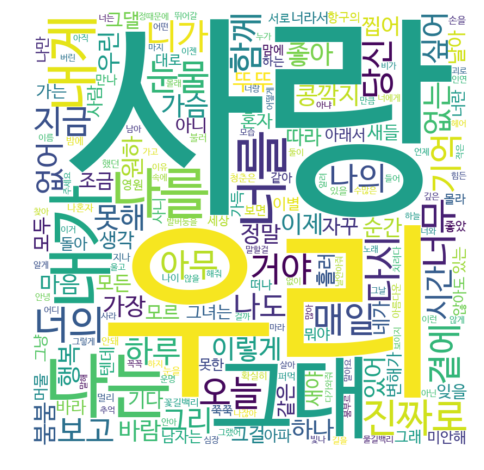

In [86]:
# 워드클라우드 이미지 출력하고 저장하기
fig = plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
fig.savefig('wordcloud.png')